# Code and updates for existing code to make xml's for whole slide inference masks

## Overview
- I improved the cv2_polygonize function
    - easy handling if processing spacing and saving output correctly to wsi spacing
    - allow to simplify polygons
    - correct removel of holes, without filling, allowing to keep annotations WITHIN holes

- Improved convert_polygons_to_annotations
    - The one currenctly on whole slide data tries to set class properties via kwargs into the class init, but this is not possible. Probably somthing that was not tested after before pushing
    
- Improved the main function
    - bringing averything together
    - file naming
    - overwrite
    - return things for debugging
    - simpligy
    - union
    - processing_spacing

In [1]:
from pathlib import Path
from xmlrpc.client import boolean
# import click
from shapely import geometry
from shapely.ops import unary_union
from wholeslidedata.interoperability.asap.annotationwriter import write_asap_annotation
from wholeslidedata.annotation.types import Annotation
# from wholeslidedata.annotation.utils import cv2_polygonize
from wholeslidedata.image.wholeslideimage import WholeSlideImage
from wholeslidedata.annotation.labels import Label
from shapely.geometry import Polygon, MultiPolygon
from tqdm import tqdm
from scipy.ndimage import binary_erosion, binary_dilation, binary_fill_holes
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from wholeslidedata.annotation.utils import write_json_annotations

In [2]:
import os

current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"
current_os

def convert_path(path, to=current_os):
    if to in ["w", "win", "windows"]:
        path = path.replace("/mnt/pa_cpg", "Y:")
        path = path.replace("/data/pathology", "Z:")
        path = path.replace("/mnt/pa_cpgarchive1", "W:")
        path = path.replace("/mnt/pa_cpgarchive2", "X:")
        path = path.replace("/", "\\")
    if to in ["u", "unix", "l", "linux"]:
        path = path.replace("Y:", "/mnt/pa_cpg")
        path = path.replace("Z:", "/data/pathology")
        path = path.replace("W:", "/mnt/pa_cpgarchive1")
        path = path.replace("X:", "/mnt/pa_cpgarchive2")
        path = path.replace("\\", "/")
    return path

# NEW cv2_polygonize

### FINAL POLYGONIZE FUNCTION
This makes use of hierarchy via cv.RETR_CCOMP, which allows to separate holes from outer edges. The previous fill_holes approach failed to recognise annotations within a hole of an annotation of the same class. for example, tumor surrounded by stroma, surrounded by tumor

for this example we only need 3 polygons is we let whole slide data know the label sampler (i believe) needs to SORT (think its called 'sorters') based on area. In the example above, the polygons we would need are the outer tumor's outer edge, the stroma outer edge and the inner tumor outer edge. Using the previous fill_holes approach we would only keep the outer outer tumor and the outer stroma. Without fill_holes we would have the outer and inner edge of the outer tumor, the outer and inner edge if the stroma and the outer edge of the inner tumor --> 5 paths, while we only need 3. Using the new approach we remove holes (inner edges) while keeping outer edges. 

In [3]:
def polygon_value_and_index_to_outer_inner(value, index, hierarchies_dict):
    hierarchy = hierarchies_dict[value][index]
    return 'outer' if hierarchy[3]==-1 else 'inner'

In [4]:
def polygons_dict_to_outer_polygons_dict(polygons_dict, hierarchies_dict, inv_label_map=None):
    polygons_outer_dict = {}
    for value, polygons in polygons_dict.items():
        # if isinstance(polygons, type(None)):
        #     polygons_outer_dict[value] = None
        polygons_outer = [polygon for polygon_idx, polygon in enumerate(polygons) \
                          if polygon_value_and_index_to_outer_inner(value, polygon_idx, hierarchies_dict) == 'outer']
        label_name = f'class value {value}'
        if inv_label_map:
            label_name=inv_label_map[value]
        print(f'\t\t{label_name}: \n\t\t\tfrom {len(polygons)} polygons, {len(polygons_outer)} were outer, {len(polygons) - len(polygons_outer)} holes were removed')
        polygons_outer_dict[value] = polygons_outer
    return polygons_outer_dict

In [5]:
def cv2_polygonize_with_hierarchy(
    mask, dilation_iterations=0, erose_iterations=0, exclude_holes=True, values=None, inv_label_map=None
):
    # mask=mask+1 # +1 so the background class is also precicted correctly
    if values is None:
        values = np.unique(mask)

    all_polygons = {}
    all_hierarchies = {}

    for value in values:
        print(f'\t\tprocessing value {value}{f", {inv_label_map[value]}" if inv_label_map else ""}')
        
        tmp_mask = (mask == value).astype(np.uint8) # improved here, allowing to extraxt background polygons (if you dont want background, exclude its value from 'values' input)

        if dilation_iterations > 0:
            tmp_mask = binary_dilation(tmp_mask, iterations=dilation_iterations).astype(
                np.uint8
            )
        if erose_iterations > 0:
            tmp_mask = binary_erosion(tmp_mask, iterations=erose_iterations).astype(
                np.uint8
            )

        tmp_mask = np.pad(
            array=tmp_mask, pad_width=1, mode="constant", constant_values=0
        )

        polygons, hierarchies = cv2.findContours(
            tmp_mask.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE, offset=(-1, -1) #cv2.RETR_CCOMP retuns hierarchy with outer/hole inforamtion
        )
        
        
        if len(polygons)==0:
            all_polygons[value] = []
            all_hierarchies[value] = []
            continue
        
        # remove instances with <3 coordinates
        filtered_polygonsand_hierarchies = [(np.array(polygon[:, 0, :]), hierarchy)
                for polygon, hierarchy in zip(polygons, hierarchies[0])
                if len(polygon) >= 3]
        if len(filtered_polygonsand_hierarchies) == 0:
            all_polygons[value] = []
            all_hierarchies[value] = []
            continue
        polygons, hierarchies = zip(*filtered_polygonsand_hierarchies)
        
        all_polygons[value] = polygons 
        all_hierarchies[value] = hierarchies
        
    
    if exclude_holes:
        print('\tRemoving hole polygons')
        all_polygons = polygons_dict_to_outer_polygons_dict(all_polygons, all_hierarchies, inv_label_map)
    
    return all_polygons

# Adjusted current convert_polygons_to_annotations
adjusted for kwargs. This has changed but was not updated correctly

In [6]:
def convert_polygons_to_annotations(polygons, inv_label_map, color_map):
    annotation_structures = []
    index = 0
    for value, polys in polygons.items():
        for polygon in polys:
            p = geometry.Polygon(polygon).buffer(0)
            label = Label(
                name=inv_label_map[value],
                value=value,
                color=color_map[inv_label_map[value]]
            )
            if isinstance(p, geometry.MultiPolygon):
                for q in list(p):
                    annotation_structure = dict(
                        index=index,
                        # type="polygon",
                        label=label.todict(),
                        coordinates=q.exterior.coords,
                        # holes=[],
                    )
                    annotation_structures.append(annotation_structure)
                    index += 1
            else:
                annotation_structure = dict(
                    index=index,
                    # type="polygon",
                    label=label.todict(),
                    coordinates=p.exterior.coords,
                    # holes=[],
                )
                annotation_structures.append(annotation_structure)
                index += 1

    annotations = []
    for annotation_structure in annotation_structures:
        if len(annotation_structure["coordinates"]) >= 3:
            try:
                annotation = Annotation.create(**annotation_structure)
            except Exception as e:
                print(annotation_structure["coordinates"])
                raise e
            annotations.append(annotation)
    return annotations

# MAIN function

In [7]:
# def main_new(
#     mask_path: Path,
#     output_folder: Path,
#     processing_spacing: float,
#     label_mapping: tuple = (),
#     color_mapping: tuple = (),
#     dilation_iterations: int = 0,
#     erose_iterations: int = 0,
#     exclude_holes: bool = True,
#     mask_wsi_spacing_ratio: float = 1,
#     simplify=None,
#     union=False,
#     filename_tail="",
#     verbose=True,
#     overwrite=False,
#     ret=False
# ):
#     inv_label_map = {value:name.lower() for value, name in label_mapping.items()}
#     color_map = {name.lower():color for name, color in color_mapping.items()}
    
#     if not mask_path.exists():
#         raise ValueError(f"mask path {mask_path} does not exists")

#     if mask_path.is_dir():
#         mask_paths = list(mask_path.glob('*.tif'))
#     else:
#         mask_paths = [mask_path]
    
    
#     for mask_path in tqdm(mask_paths):
#         print('processing', mask_path)
#         output_path = output_folder / (mask_path.stem + filename_tail + ".xml")
#         if not overwrite and output_path.exists():
#             print(f'Output path already exist: {output_path}')
#             if ret:
#                 print('Returning None, None')
#                 return None, None
#             return
#         if verbose:
#             print('\tLoading files')
#         mask = WholeSlideImage(mask_path, backend="asap")
#         mask_slide = mask.get_slide(processing_spacing).squeeze()
#         ratio = mask.get_downsampling_from_spacing(processing_spacing) * mask_wsi_spacing_ratio
        
#         if verbose:
#             print('\tMaking polygons from mask')
#         polygons = cv2_polygonize_with_hierarchy(
#             mask_slide,
#             dilation_iterations=dilation_iterations,
#             erose_iterations=erose_iterations,
#             exclude_holes=exclude_holes,
#             values=list(inv_label_map),
#             inv_label_map=inv_label_map
#         )
        
# #         return polygons
# # ######
#         for value, polys in polygons.items():
#             for poly_idx, poly in enumerate(polys):
#                 polygons[value][poly_idx] = geometry.Polygon(poly)
#         if simplify:
#             polygons = {k: [v.simplify(simplify) for v in v_list] for k, v_list in polygons.items()}
#         if union:
#             polygons = {k:unary_union(v) if k!=0 else v for k, v in polygons.items()}
    
#         if verbose:
#             print('\tMaking annotations from polygons')
#         annotations = convert_polygons_to_annotations(
#             polygons=polygons, inv_label_map=inv_label_map, color_map=color_map
#         )
#         # return annotations
            
# ######
#         if verbose:
#             print('\tWriting XML')
#         print('\t\tRatio', ratio)
#         print('\t\tWriting to:', output_path)
#         write_asap_annotation(annotations=annotations, output_path=output_path, color_map=color_map, scaling=ratio)
#         if ret:
#             return polygons, annotations

In [8]:
from typing import List, Optional
def convert_annotations_to_json(annotations: List[Annotation], scaling: Optional[float] = None):
    output = []
    for annotation in annotations:
        item = annotation.todict()
        if scaling is not None:
            new_coordinates = [[coord[0] * scaling, coord[1] * scaling] for coord in item['coordinates']]
            item['coordinates'] = new_coordinates
        output.append(item)
    return output

In [9]:
def main_new(
    mask_path: Path,
    output_folder: Path,
    processing_spacing: float,
    label_mapping: tuple = (),
    color_mapping: tuple = (),
    dilation_iterations: int = 0, # dont use
    erose_iterations: int = 0,  # dont use
    exclude_holes: bool = True, # shoud be true for whole slide data 
    mask_wsi_spacing_ratio: float = 1,
    simplify=None,
    union=False,
    filename_tail="",
    verbose=True,
    write_additional_json=False,
    overwrite=False,
    ret=False # debugging
):
    inv_label_map = {value:name.lower() for value, name in label_mapping.items()}
    color_map = {name.lower():color for name, color in color_mapping.items()}
    
    if not mask_path.exists():
        raise ValueError(f"Mask path {mask_path} does not exists")

    if mask_path.is_dir():
        mask_paths = list(mask_path.glob('*.tif'))
    else:
        mask_paths = [mask_path]
    
    
    for mask_path in tqdm(mask_paths):
        print('processing', mask_path)
        output_path = output_folder / (mask_path.stem + filename_tail)
        
        output_path_xml = output_path.with_suffix('.xml')
        output_path_json = output_path.with_suffix('.json')
        
        output_path_xml_exists = output_path_xml.exists()
        output_path_json_exists = output_path_json.exists()
        
        if not overwrite and output_path_xml_exists and (output_path_json_exists if write_additional_json else True):
            print(f'Output file(s) already exist: {output_path_xml} (and optionally its .json)')
            if ret:
                print('Returning None, None')
                return None, None
            return
        
        if verbose:
            print('\tLoading files')
        mask = WholeSlideImage(mask_path, backend="asap")
        mask_slide = mask.get_slide(processing_spacing).squeeze()
        ratio = mask.get_downsampling_from_spacing(processing_spacing) * mask_wsi_spacing_ratio
        
        if verbose:
            print('\tMaking polygons from mask')
        polygons = cv2_polygonize_with_hierarchy(
            mask_slide,
            dilation_iterations=dilation_iterations,
            erose_iterations=erose_iterations,
            exclude_holes=exclude_holes,
            values=list(inv_label_map),
            inv_label_map=inv_label_map
        )
        
#         return polygons
# ######
        for value, polys in polygons.items():
            for poly_idx, poly in enumerate(polys):
                polygons[value][poly_idx] = geometry.Polygon(poly)
        if simplify:
            polygons = {k: [v.simplify(simplify) for v in v_list] for k, v_list in polygons.items()}
        if union:
            polygons = {k:unary_union(v) if k!=0 else v for k, v in polygons.items()}
    
        if verbose:
            print('\tMaking annotations from polygons')
        annotations = convert_polygons_to_annotations(
            polygons=polygons, inv_label_map=inv_label_map, color_map=color_map
        )
        # return annotations
            
######
        if verbose:
            print('\tWriting XML')
            print('\t\tRatio', ratio)
            print('\t\tWriting to:', output_path_xml)
        write_asap_annotation(annotations=annotations, output_path=output_path_xml, color_map=color_map, scaling=ratio)
        
        if write_additional_json:
            if verbose:
                print('\tWriting JSON')
                print('\t\tWriting to:', output_path_json)
            annotations_json = convert_annotations_to_json(annotations, scaling=ratio)
            write_json_annotations(output_path_json, annotations_json)
            
        if ret:
            print('[Ret == True] --> Returning polygons, annotations')
            return polygons, annotations

# PREPARATION

## The masks

In [10]:
masks_folder = convert_path(r'Z:\projects\pathology-lung-TIL\nnUNet_raw_data_base\inference_results\Task020_WSI_on_train_batch_1_3')
mask_paths = [Path(os.path.join(masks_folder, file_name)) for file_name in os.listdir(masks_folder) if file_name.endswith('nnunet.tif')]
mask_path = mask_paths[0]

## Labels

In [11]:
labels={'Background':0,
        'Tumor': 1, 
        'Stroma': 3, 
        'Inflammation': 4, 
        'Healthy parenchyma': 5, 
        'Fatty tissue': 6, 
        'Necrotic tissue': 7, 
        'Erytrocytes': 8, 
        'Healthy epithelium': 9, 
        'Mucus': 10, 
        'Cartilage': 11,
        'Macrophages': 12,
        'Other': 13,
       }
label_mapping = {v:k for k,v in labels.items()}

## Plot stuff

{'Background': '#000000', 'Tumor': '#00E0F9', 'Stroma': '#AEF900', 'Inflammation': '#F96400', 'Healthy parenchyma': '#F9007D', 'Fatty tissue': '#9500F9', 'Necrotic tissue': '#0000CE', 'Erytrocytes': '#00B9CE', 'Healthy epithelium': '#00CE29', 'Mucus': '#8FCE00', 'Cartilage': '#CE5200', 'Macrophages': '#CE0067', 'Other': '#7C00CE'}


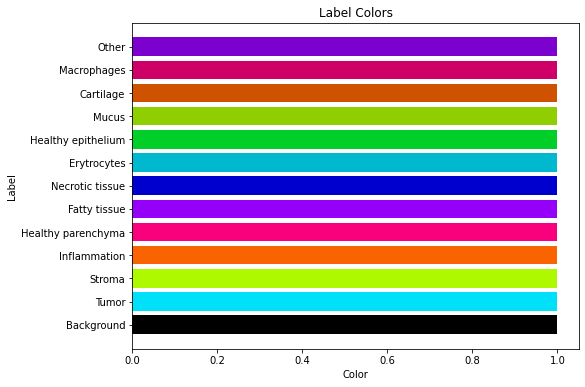

In [12]:
original_colormap = [ [0, 0, 0, 255], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 0, 249, 50, 255 ] ]

# Create a dictionary that maps label names to their corresponding hex colors
color_mapping = {
    label: "#{:02X}{:02X}{:02X}".format(*original_colormap[index][0:3])
    for label, index in labels.items()
}

# Print the resulting dictionary
print(color_mapping)

# Create a simple bar chart to visualize the labels and colors
fig, ax = plt.subplots(figsize=(8, 6))

for label, color in color_mapping.items():
    ax.barh(label, 1, color=color)

ax.set_xlabel("Color")
ax.set_ylabel("Label")
ax.set_title("Label Colors")

plt.show()

# TEST RUNS 

## Testing new exclude holes approach

### Settings

In [13]:
# spacing = 4
dilation_iterations = 0
erose_iterations = 0
fill_holes = False
wsi_spacing = 0.25
mask_spacing = 0.5
mask_wsi_spacing_ratio = mask_spacing / wsi_spacing

In [14]:
# output_folder_exlude_holes = Path(convert_path(r"Z:\projects\pathology-lung-TIL\data\self_supervision\simplify_exclude_holes_tests"))
# os.makedirs(output_folder_exlude_holes, exist_ok=True)

In [15]:
output_folder_exlude_holes = Path(convert_path(r"Z:\projects\pathology-lung-TIL\data\self_supervision\simplify_exclude_holes_tests_TEST"))
os.makedirs(output_folder_exlude_holes, exist_ok=True)

In [16]:
import time

exclude_holes=True
mask_path = mask_paths[0]
overwrite = False
union=False

for simplify in [8]:
    for processing_spacing in [8]:
        # Record the start time
        print(f'[spacing {processing_spacing}, simplify {simplify}, union {union}, exclude_holes {exclude_holes}]')
        output_filename = f'_spacing{processing_spacing}_simplify{str(simplify).replace(".", "")}{"_union" if union else ""}{"_EXCLUDE_holes" if exclude_holes else ""}'
        # print(output_filename)

        start_time = time.time()

        # Call the main function
        polygons, annotations = main_new(
            mask_path=Path(mask_path),
            output_folder=Path(str(output_folder_exlude_holes)),
            processing_spacing=processing_spacing,
            label_mapping=label_mapping,
            color_mapping=color_mapping,
            dilation_iterations=dilation_iterations,
            erose_iterations=erose_iterations,
            exclude_holes=exclude_holes, 
            mask_wsi_spacing_ratio=mask_wsi_spacing_ratio,
            simplify=simplify,
            union=union,
            filename_tail=output_filename,
            overwrite=overwrite,
            ret=True,
        )

        # Record the end time
        end_time = time.time()

        # Calculate the elapsed time
        elapsed_time = end_time - start_time

        # Print the elapsed time
        print(f'Done in {elapsed_time:.2f} seconds\n\n')
print('DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

[spacing 8, simplify 8, union False, exclude_holes True]


  0%|          | 0/1 [00:00<?, ?it/s]

processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000060_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/simplify_exclude_holes_tests_TEST/LI_S01_P000060_C0001_L01_A15_nnunet_spacing8_simplify8_EXCLUDE_holes.xml (and optionally its .json)
Returning None, None
Done in 0.01 seconds


DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


# FULL RUNS

In [21]:
mask_path = mask_paths[0]
output_parent_folder = Path(convert_path(r"Z:\projects\pathology-lung-TIL\data\self_supervision\batch1_3_xmls"))

processing_spacing = 4
wsi_spacing = 0.25
mask_spacing = 0.5
mask_wsi_spacing_ratio = mask_spacing / wsi_spacing

simplify = 8
union = False
exclude_holes = True

dilation_iterations = 0
erose_iterations = 0

overwrite=False
write_additional_json = True

In [23]:
for mask_idx, mask_path in enumerate(mask_paths):
    print(f'[MASK [{mask_idx+1}/{len(mask_paths)}]: {Path(mask_path).stem}] \nspacing {processing_spacing}, simplify {simplify}, union {union}, exclude_holes {exclude_holes}')
    
    filename_tail = f'_spacing{processing_spacing}_simplify{str(simplify).replace(".", "")}{"_exclude_holes" if exclude_holes else ""}'
    output_folder = output_parent_folder / filename_tail.strip('_')
    os.makedirs(output_folder, exist_ok=True)
    
    # Record the start time
    start_time = time.time()

    # Call the main function
    main_new(
        mask_path=Path(mask_path),
        output_folder=Path(output_folder),
        processing_spacing=processing_spacing,
        label_mapping=label_mapping,
        color_mapping=color_mapping,
        dilation_iterations=dilation_iterations,
        erose_iterations=erose_iterations,
        exclude_holes=exclude_holes, 
        mask_wsi_spacing_ratio=mask_wsi_spacing_ratio,
        simplify=simplify,
        union=union,
        filename_tail=filename_tail,
        write_additional_json=write_additional_json,
        overwrite=overwrite,
        ret=False,
    )

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    # Print the elapsed time
    print(f'Done in {elapsed_time:.2f} seconds\n\n')
print('DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

[MASK [1/30]: LI_S01_P000060_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000060_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000060_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [2/30]: LI_S01_P000004_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000004_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000004_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.02 seconds


[MASK [3/30]: LI_S01_P000036_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000036_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000036_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.02 seconds


[MASK [4/30]: EX_S09_P000101_C0001_B101_V02_T01_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/EX_S09_P000101_C0001_B101_V02_T01_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/EX_S09_P000101_C0001_B101_V02_T01_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [5/30]: LI_S01_P000001_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000001_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000001_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.02 seconds


[MASK [6/30]: LI_S01_P000002_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000002_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000002_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [7/30]: EX_S09_P000166_C0001_B101_V03_T01_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/EX_S09_P000166_C0001_B101_V03_T01_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/EX_S09_P000166_C0001_B101_V03_T01_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [8/30]: 11445_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/11445_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/11445_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.02 seconds


[MASK [9/30]: EX_S09_P000066_C0001_B101_V01_T01_E001_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/EX_S09_P000066_C0001_B101_V01_T01_E001_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/EX_S09_P000066_C0001_B101_V01_T01_E001_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [10/30]: LI_S01_P000059_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000059_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000059_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [11/30]: EX_S09_P000155_C0001_B101_V01_T01_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/EX_S09_P000155_C0001_B101_V01_T01_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/EX_S09_P000155_C0001_B101_V01_T01_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [12/30]: LI_S01_P000017_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000017_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000017_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.03 seconds


[MASK [13/30]: LI_S01_P000043_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]

processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000043_C0001_L01_A15_nnunet.tif


  0%|          | 0/1 [00:00<?, ?it/s]


Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000043_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [14/30]: EX_S09_P000077_C0001_B101_V02_T01_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/EX_S09_P000077_C0001_B101_V02_T01_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/EX_S09_P000077_C0001_B101_V02_T01_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [15/30]: LI_S01_P000026_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000026_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000026_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.03 seconds


[MASK [16/30]: LI_S01_P000015_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000015_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000015_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.02 seconds


[MASK [17/30]: LI_S01_P000040_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]

processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000040_C0001_L01_A15_nnunet.tif


  0%|          | 0/1 [00:00<?, ?it/s]


Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000040_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.03 seconds


[MASK [18/30]: LI_S01_P000010_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000010_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000010_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.02 seconds


[MASK [19/30]: LI_S01_P000023_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]

processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000023_C0001_L01_A15_nnunet.tif


  0%|          | 0/1 [00:00<?, ?it/s]


Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000023_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [20/30]: LI_S01_P000022_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]

processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000022_C0001_L01_A15_nnunet.tif


  0%|          | 0/1 [00:00<?, ?it/s]


Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000022_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.02 seconds


[MASK [21/30]: LI_S01_P000013_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]

processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000013_C0001_L01_A15_nnunet.tif


  0%|          | 0/1 [00:00<?, ?it/s]


Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000013_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.02 seconds


[MASK [22/30]: LI_S01_P000047_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000047_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000047_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.02 seconds


[MASK [23/30]: LI_S01_P000021_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000021_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000021_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [24/30]: LI_S01_P000018_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]

processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000018_C0001_L01_A15_nnunet.tif


  0%|          | 0/1 [00:00<?, ?it/s]


Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000018_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.02 seconds


[MASK [25/30]: LI_S01_P000019_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000019_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000019_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.02 seconds


[MASK [26/30]: EX_S09_P000162_C0001_B101_V03_T01_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]

processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/EX_S09_P000162_C0001_B101_V03_T01_nnunet.tif


  0%|          | 0/1 [00:00<?, ?it/s]


Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/EX_S09_P000162_C0001_B101_V03_T01_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [27/30]: EX_S09_P000139_C0001_B101_V04_T01_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/EX_S09_P000139_C0001_B101_V04_T01_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/EX_S09_P000139_C0001_B101_V04_T01_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [28/30]: LI_S01_P000029_C0001_L01_A15_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/LI_S01_P000029_C0001_L01_A15_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/LI_S01_P000029_C0001_L01_A15_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [29/30]: EX_S09_P000127_C0001_B101_V02_T01_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]


processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/EX_S09_P000127_C0001_B101_V02_T01_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/EX_S09_P000127_C0001_B101_V02_T01_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


[MASK [30/30]: EX_S09_P000001_C0001_B101_V04_T01_E002_nnunet] 
spacing 4, simplify 8, union False, exclude_holes True


  0%|          | 0/1 [00:00<?, ?it/s]

processing /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task020_WSI_on_train_batch_1_3/EX_S09_P000001_C0001_B101_V04_T01_E002_nnunet.tif
Output file(s) already exist: /data/pathology/projects/pathology-lung-TIL/data/self_supervision/batch1_3_xmls/spacing4_simplify8_exclude_holes/EX_S09_P000001_C0001_B101_V04_T01_E002_nnunet_spacing4_simplify8_exclude_holes.xml (and optionally its .json)
Done in 0.01 seconds


DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


# WIP CODE

In [19]:
1/0

ZeroDivisionError: division by zero

In [ ]:
polygons, annotations = main_new(
            mask_path=Path(mask_path),
            output_folder=Path(str(output_folder_exlude_holes)),
            processing_spacing=processing_spacing,
            label_mapping=label_mapping,
            color_mapping=color_mapping,
            dilation_iterations=dilation_iterations,
            erose_iterations=erose_iterations,
            exclude_holes=exclude_holes, 
            mask_wsi_spacing_ratio=mask_wsi_spacing_ratio,
            simplify=simplify,
            union=union,
            filename_tail=output_filename,
            overwrite=True,
            ret=True,
        )

# Temp background improvement working code

The problem here is that the biggest background polygon covers the full image (its all background around the tissue). Sampling background in fully white areas is suboptimal, therefore this polygon should be reduced to a boundary around the tissue 

In [ ]:
def tissue_mask_to_background_polygons(tissue_mask): # tissue mask is 1 for all tissue and 0 for background
    tissue_mask = binary_fill_holes(tissue_mask).astype(np.uint8)
    polygons, hierarchies = cv2.findContours((tissue_mask).astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE, offset=(-1, -1))
    polygons, hierarchies = zip(*[(np.array(polygon[:, 0, :]), hierarchy) \
                                          for polygon, hierarchy in zip(polygons, hierarchies[0]) \
                                          if len(polygon) >= 3])
    polygons = [Polygon(polygon) for polygon in polygons]
    return polygons

In [ ]:
def buffer_and_remove_holes(geometries, buffer=16, simplify=4):
    # Perform unary union to merge all the geometries
    union_geometry = unary_union(geometries).buffer(buffer).simplify(simplify)

    # Check if the result is a MultiPolygon
    if isinstance(union_geometry, MultiPolygon):
        # Create a list of the exteriors of all polygons
        exteriors = [Polygon(polygon.exterior) for polygon in union_geometry]

        # Create a new MultiPolygon from the exteriors
        no_holes_polygon = MultiPolygon(exteriors)
    else:
        # If the result is not a MultiPolygon, you may have a single Polygon with no holes
        no_holes_polygon = union_geometry

    return no_holes_polygon

In [ ]:
### May be that there is something in the function below that is not in the function above
# def union_background_polygons_to_buffered_exterior(buffered_polygons_union):
#     # Check if the result is a MultiPolygon
#     if isinstance(union_geometry, MultiPolygon):
#         # Convert MultiPolygon to a Polygon without holes
#         if union_geometry.is_valid:
#             # If the result is valid, create a Polygon from the exterior of the first polygon
#             no_holes_polygon = Polygon(union_geometry[0].exterior)
#         else:
#             # If the result is invalid, use buffer(0) to fix it
#             no_holes_polygon = Polygon(union_geometry[0].buffer(0))
#     else:
#         # If the result is not a MultiPolygon, you may have a single Polygon with no holes
#         no_holes_polygon = union_geometry
#     return no_holes_polygon

In [ ]:
def get_biggest_polygon_index(polygon_or_coordinates_list):
    polygon_areas = [Polygon(p).area for p in polygon_or_coordinates_list]   
    return polygon_areas.index(max(polygon_areas))

In [ ]:
mask_slide = WholeSlideImage(mask_paths[1], backend='asap').get_slide(spacing=8)
tissue_mask = (mask_slide!=0).squeeze()

In [ ]:
background_polygons = tissue_mask_to_background_polygons(tissue_mask)
background_polygons = buffer_and_remove_holes(background_polygons)

In [ ]:
background_polygons

Now write this one and remove the biggest one

In [ ]:
get_biggest_polygon_index(polygons[0])

In [ ]:
polygons[0][get_biggest_polygon_index(polygons[0])]

# Temp code for improving removal of very small polygons

The problem here is that in the inference maps there are a lot of small polygons that contain about no information, but are very abundant in the xml. 

This is troublesome for cpu usage during sampling (probably, struggling with this) and these are probably false positives expecially for coarse polygons on high processing spacing, and they are sampled a lot compared to bigger annotations (due to standard sqrt normalised area sampling in nnuNet)

In [ ]:
annotations[200].area

In [ ]:
import pandas as pd

In [ ]:
all_areas = [Polygon(p).area for polygons_class in polygons for p in polygons[polygons_class]]

In [ ]:
all_class_areas = {polygons_class : [Polygon(p).area for p in polygons[polygons_class]] for polygons_class in polygons}

In [ ]:
inv_labels = {v:k for k, v in labels.items()}

In [ ]:
data = []
for value, class_areas in all_class_areas.items():
    data.append([inv_labels[value], len(class_areas), sum(np.array(class_areas) <= 1), round(sum(np.array(class_areas) <= 1)/(len(class_areas)+0.000001), 2)])
df = pd.DataFrame(data, columns=['label', 'total count', 'count <1', 'perenctage <1'])

In [ ]:
df

In [ ]:
df[['total count', 'count <1']].sum(axis=0).values
19852/76438

In [ ]:
sum(np.array(all_areas) <= 1), sum(np.array(all_areas) <= 1)/len(all_areas)

# VISUALIZE

In [ ]:
1/0

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
# import pylab as plt

# colormap = [ [ 0, 0, 0, 0 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 0, 249, 50, 255 ] ]
colormap = [ [ 0, 0, 0, 0 ], [ 0, 229, 248, 255 ], [ 0, 249, 50, 255 ], #bg, t, ---
            [ 175, 255, 42, 255 ], [ 255, 110, 58, 255 ], [ 239, 0, 150, 255 ], # s, i, hp
            [ 132,0,205, 255 ], [ 0, 48, 111, 255 ], [ 126, 0, 24, 255 ], # f, n, e
            [ 0,149,3, 255 ], [134, 255, 222, 255 ], [ 216, 216, 216, 255 ], #he muc, ca
            [ 0, 115, 92, 255 ], [ 80, 80, 80, 255 ], #ma, o
            
            [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 0, 249, 50, 255 ] ]

colormap = np.array(colormap)/255.
cmap = LinearSegmentedColormap.from_list('my_cmap', colors=colormap)

label_names = ['Background', 
               'Tumor',
               'Healthy stroma',
               'Tumor-associated stroma', 
               'Inflammation',
               'Healthy parenchyma', 
               'Fatty tissue', 
               'Necrotic tissue', 
               'Erytrocytes', 
               'Healthy epithelium',
               'Mucus', 
               'Cartilage',
               'Macrophages',
               'Other']

label_names_stroma_merge = ['Background', 
               'Tumor',
               'Stroma', 
               'Inflammation',
               'Healthy parenchyma', 
               'Fatty tissue', 
               'Necrotic tissue', 
               'Erytrocytes', 
               'Healthy epithelium',
               'Mucus', 
               'Cartilage',
               'Macrophages',
               'Other']
label_index = list(range(len(label_names)))
label_index_stroma_merge = list(range(len(label_names)))
del label_index_stroma_merge[2]
label_plot_args = {"cmap":cmap, "vmin":0, "vmax":255, "interpolation":"none"}

%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[-1].imshow([[i] for i in list(range(14))], 
                vmin=0, vmax=255, cmap=cmap, interpolation='nearest')
axs[-1].set_yticks(label_index)
axs[-1].set_yticklabels(label_names)
axs[-1].yaxis.tick_right()
axs[-1].get_xaxis().set_visible(False)
axs[-1].set_title("Labels")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[-1].imshow([[i] for i in label_index_stroma_merge], 
                vmin=0, vmax=255, cmap=cmap, interpolation='nearest')
axs[-1].set_yticks(range(len(label_index_stroma_merge)))
axs[-1].set_yticklabels(label_names_stroma_merge)
axs[-1].yaxis.tick_right()
axs[-1].get_xaxis().set_visible(False)
axs[-1].set_title("Labels")
plt.show()

n_labels = len(label_index_stroma_merge)

In [ ]:
from wholeslidedata import WholeSlideImage, WholeSlideAnnotation
from wholeslidedata.samplers.patchlabelsampler import SegmentationPatchLabelSampler
from wholeslidedata.interoperability.asap.parser import AsapAnnotationParser
from shapely.geometry import Point

In [ ]:
wsi_path = Path(convert_path(r"Z:\projects\pathology-lung-TIL\data\self_supervision\Task020_batch1_3_to_train_BN_bs8_ps512_stroma_merge\nnUNetTrainerV2_BN_pathology_DA_hed005__nnUNet_RGB_scaleTo_0_1_bs8_ps512\LI_S01_P000060_C0001_L01_A15.tif"))
wsa_path = Path(convert_path(r"Z:\projects\pathology-lung-TIL\data\self_supervision\Task020_WSI_on_train_batch_1_3_XML\LI_S01_P000060_C0001_L01_A15_nnunet.xml"))

In [ ]:
labels={'rois': 0,
        'Background':0,
        'Tumor': 1, 
        'Stroma': 3,
        'Healthy stroma': 3,########################################################## MERGED STROMA 
        'Tumor-associated stroma': 3, 
        'Inflammation': 4, 
        'Healthy parenchyma': 5, 
        'Fatty tissue': 6, 
        'Necrotic tissue': 7, 
        'Necrosis' : 7,
        'Erytrocytes': 8, 
        'Healthy epithelium': 9, 
        'Healty epithelium': 9,  #typo in annotated data
        'Mucus': 10, 
        'Cartilage': 11,
        'Macrophages': 12,
        'Other': 13,
#         'Anthracosis': 13
       }

In [ ]:
label_sampler = SegmentationPatchLabelSampler()
parser = AsapAnnotationParser(labels=labels)

In [ ]:
wsi = WholeSlideImage(wsi_path)
wsa = WholeSlideAnnotation(wsa_path, parser=parser)

In [ ]:
x = 245000 #257800 #245000
y = 157000 #150000 #157000

size = 1024
spacing = 2
wsi_spacing = 0.25
ratio = spacing / wsi_spacing

num_plots_with_labels = 4
figsize = (15, 15)
ax_ratio = (14, 1)

In [ ]:
roi_patch = wsi.get_patch(x=x, y=y, width=size, height=size, spacing=spacing)
mask_patch = label_sampler.sample(wsa, (x, y), (size, size), ratio=ratio)

In [ ]:
fig, axs = plt.subplots(1, num_plots_with_labels, figsize=figsize, gridspec_kw={'width_ratios': (num_plots_with_labels-1)*[ax_ratio[0]]+ [ax_ratio[-1]]})
axs[0].imshow(roi_patch)
axs[1].imshow(mask_patch, **label_plot_args)
axs[2].imshow(roi_patch, **label_plot_args)
axs[2].imshow(mask_patch, alpha=0.5, **label_plot_args)
axs[-1].imshow([[i] for i in label_index_stroma_merge], 
                vmin=0, vmax=255, cmap=cmap, interpolation='nearest')
axs[-1].set_yticks(range(len(label_index_stroma_merge)))
axs[-1].set_yticklabels(label_names_stroma_merge)
axs[-1].yaxis.tick_right()
axs[-1].get_xaxis().set_visible(False)
axs[-1].set_title("Labels")
plt.show()

# Visualise

In [ ]:
from shapely.geometry import Polygon

# Define the polygons for scenario 1 and scenario 2
outer_polygon1 = Polygon([(0, 0), (0, 4), (4, 4), (4, 0)])
inner_polygon1 = Polygon([(2, 2), (2, 2.5), (2.5, 2.5), (2.5, 2)])
in_between_polygon1 = Polygon([(1, 1), (1, 3), (3, 3), (3, 1)])

outer_polygon2 = Polygon([(0, 0), (0, 4), (4, 4), (4, 0)])
inner_polygon2 = Polygon([(2, 2), (2, 2.5), (2.5, 2.5), (2.5, 2)])
in_between_polygon2 = Polygon([(1, 1), (1, 3), (3, 3), (3, 1)])

In [ ]:
outer_polygon1


In [ ]:
from matplotlib.patches import Polygon as mpl_polygon

# Create a 2D array for plotting
x = np.linspace(-1, 5, 100)
y = np.linspace(-1, 5, 100)
X, Y = np.meshgrid(x, y)

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot scenario 1 polygons
axs[0].contourf(X, Y, np.zeros_like(X), levels=[-1, 0], colors='white')
axs[0].add_patch(mpl_polygon(outer_polygon1.exterior, closed=True, fill=False, color='blue'))
axs[0].add_patch(mpl_polygon(inner_polygon1.exterior, closed=True, fill=False, color='red'))
axs[0].add_patch(mpl_polygon(in_between_polygon1.exterior, closed=True, fill=False, color='blue'))
axs[0].set_xlim(-1, 5)
axs[0].set_ylim(-1, 5)
axs[0].set_aspect('equal')
axs[0].set_title("Scenario 1")

# Plot scenario 2 polygons
axs[1].contourf(X, Y, np.zeros_like(X), levels=[-1, 0], colors='white')
axs[1].add_patch(mpl_polygon(outer_polygon2.exterior, closed=True, fill=False, color='blue'))
axs[1].add_patch(mpl_polygon(inner_polygon2.exterior, closed=True, fill=False, color='blue'))
axs[1].add_patch(mpl_polygon(in_between_polygon2.exterior, closed=True, fill=False, color='red'))
axs[1].set_xlim(-1, 5)
axs[1].set_ylim(-1, 5)
axs[1].set_aspect('equal')
axs[1].set_title("Scenario 2")

plt.show()